In [1]:
import numpy as np
import pandas as pd
from keras import models, layers

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
training_data_path = '../data/datasets/training_data_noisy_small_track_symetric_delayed_deviation.csv'
df = pd.read_csv(training_data_path)
print(f'{df.shape=}')
df.sample(5)

df.shape=(23760, 19)


,steering_angle,waypoint1_lat,waypoint1_lon,waypoint2_lat,waypoint2_lon,waypoint3_lat,waypoint3_lon,waypoint4_lat,waypoint4_lon,waypoint5_lat,waypoint5_lon,waypoint6_lat,waypoint6_lon,waypoint7_lat,waypoint7_lon,waypoint8_lat,waypoint8_lon,waypoint9_lat,waypoint9_lon
17789,-0.000000,0.529252,5.410692,-0.032814,7.591699,-1.466694,11.862209,-1.855073,15.445053,-1.699913,18.736930,-2.700458,22.271207,-2.759029,24.567471,-1.214487,28.438188,1.722339,29.642515
1422,0.000000,-1.433653,-2.307377,-3.022767,-5.312944,-4.622082,-8.313250,-6.221416,-11.313575,-7.820751,-14.313901,-9.202259,-17.409901,-8.954582,-20.734560,-6.784805,-23.305088,-3.726775,-24.748521
14979,-0.000000,-1.127140,4.801758,-1.348124,8.786487,-2.124017,11.889549,-3.245889,15.006158,-3.032054,19.140405,-1.913785,22.429663,0.058043,23.668590,3.228819,23.880275,6.047543,24.319204
21861,-0.077831,3.919660,-0.946209,5.545912,-3.913959,6.143975,-8.514242,7.416857,-11.171991,10.748063,-13.883858,10.728540,-18.119017,8.810798,-22.006108,5.101067,-25.197611,1.561515,-26.590870
6797,-0.569791,-3.978606,2.116515,-6.367828,2.860949,-9.199761,2.582421,-11.775881,1.706992,-13.853970,-0.140521,-15.736092,-2.714786,-17.599866,-5.401107,-19.160519,-8.301781,-20.759851,-11.302108


In [3]:
X = df.drop(columns=['steering_angle'])
y = df['steering_angle']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19008, 18), (4752, 18), (19008,), (4752,))

In [4]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.layers import BatchNormalization, LSTM, Dense, Reshape
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

model = Sequential([
    BatchNormalization(input_shape=(18,)),
    Reshape((9, 2)),  # reshape to sequence
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1)
])

name = 'lstm'
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint = ModelCheckpoint(f'../weights/best_{name}_{timestamp}.h5', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=1e-5, verbose=1)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 18)               72        
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 9, 2)              0         
                                                                 
 lstm (LSTM)                 (None, 128)               67072     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 75,465
Trainable params: 75,429
Non-trainable params: 36
___________________________________________________

In [5]:
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/100
594/594 [==============================] - 13s 11ms/step - loss: 0.0449 - mae: 0.1644 - val_loss: 0.0300 - val_mae: 0.1355 - lr: 0.0010
Epoch 2/100
594/594 [==============================] - 6s 10ms/step - loss: 0.0251 - mae: 0.1207 - val_loss: 0.0157 - val_mae: 0.0955 - lr: 0.0010
Epoch 3/100
594/594 [==============================] - 6s 10ms/step - loss: 0.0209 - mae: 0.1094 - val_loss: 0.0139 - val_mae: 0.0879 - lr: 0.0010
Epoch 4/100
594/594 [==============================] - 5s 9ms/step - loss: 0.0197 - mae: 0.1066 - val_loss: 0.0139 - val_mae: 0.0893 - lr: 0.0010
Epoch 5/100
594/594 [==============================] - 6s 10ms/step - loss: 0.0184 - mae: 0.1024 - val_loss: 0.0121 - val_mae: 0.0814 - lr: 0.0010
Epoch 6/100
594/594 [==============================] - 5s 9ms/step - loss: 0.0176 - mae: 0.1010 - val_loss: 0.0120 - val_mae: 0.0848 - lr: 0.0010
Epoch 7/100
594/594 [==============================] - 6s 10ms/step - loss: 0.0176 - mae: 0.1008 - val_loss: 0.0117 - v

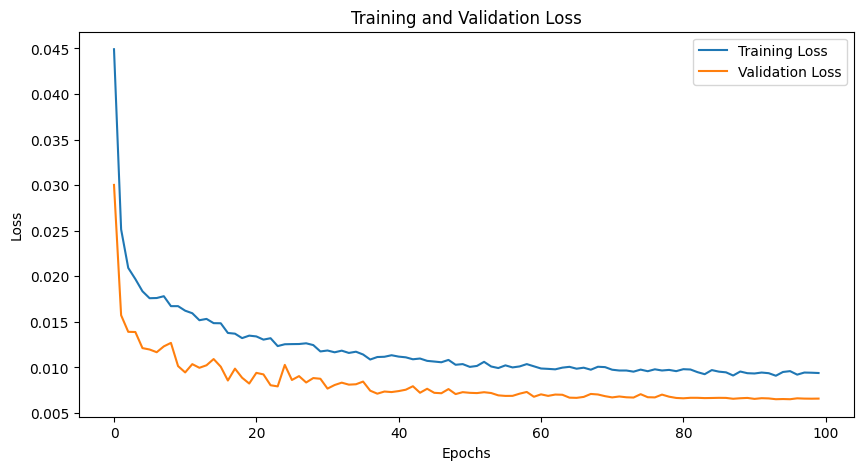

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

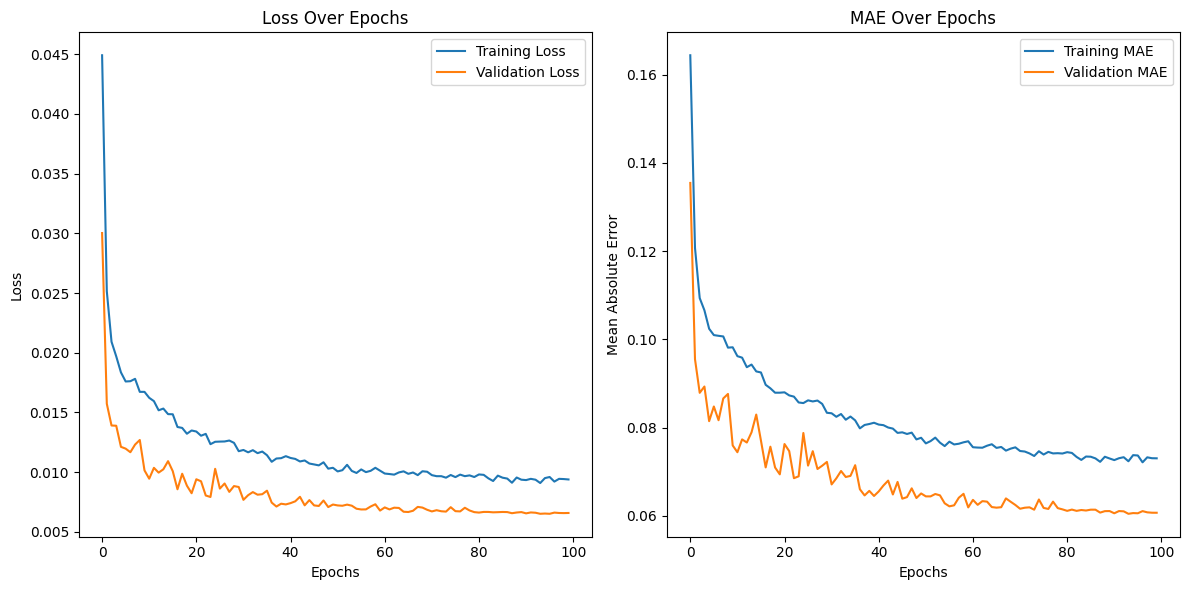

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('MAE Over Epochs')

plt.tight_layout()
plt.show()

In [8]:
model.load_weights(checkpoint.filepath)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    "Metric": ["Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "R-squared (R2)"],
    "Value": [mse, mae, r2]
})

metrics_df

149/149 [==============================] - 1s 3ms/step


,Metric,Value
0,Mean Squared Error (MSE),0.006517
1,Mean Absolute Error (MAE),0.060561
2,R-squared (R2),0.879543


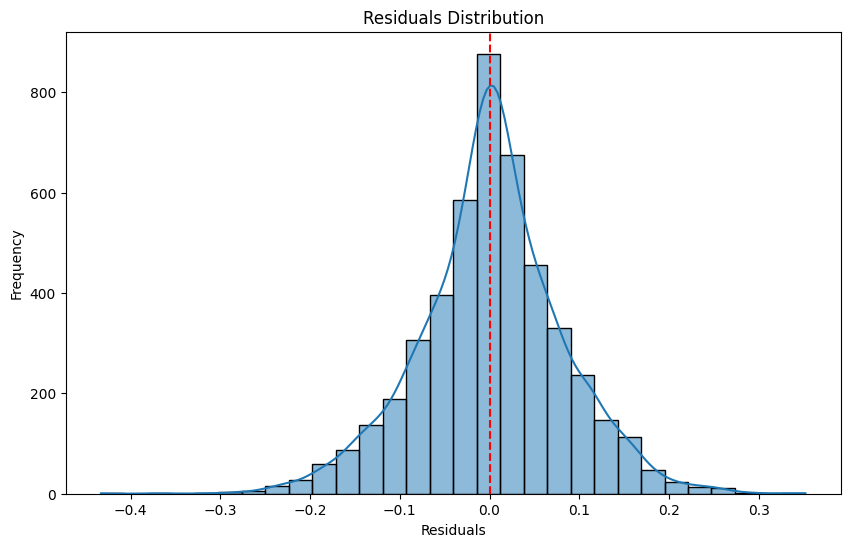

In [9]:
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

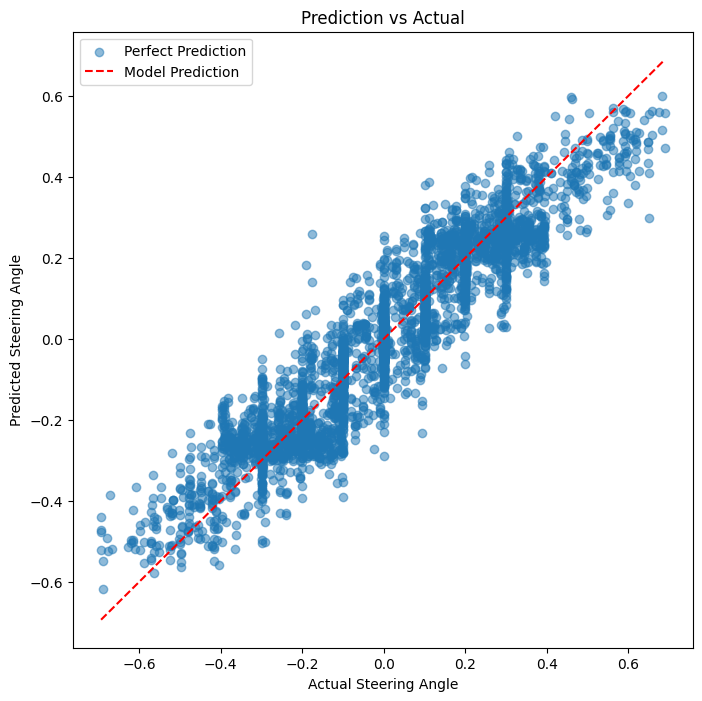

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Steering Angle')
plt.ylabel('Predicted Steering Angle')
plt.title('Prediction vs Actual')
plt.legend(['Perfect Prediction', 'Model Prediction'])
plt.show()

In [11]:
model_json = model.to_json()
with open(f'../models/{name}.json', 'w') as json_file:
    json.dump(json.loads(model_json), json_file, indent=4)

In [12]:
metadata = {
    "model_name": name,
    "model_path": f"../models/{name}.json",
    "training_data_path": training_data_path,
    "timestamp": timestamp,
    "input_shape": list(X_train.shape[1:]),
    "output_shape": [1],
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001
    },
    "loss_function": "mse",
    "metrics": ["mae"],
    "training": {
        "epochs": len(history.history['loss']),
        "batch_size": 32,
        "best_model_path": checkpoint.filepath,
        "final_training_loss": history.history['loss'][-1],
        "final_validation_loss": history.history['val_loss'][-1]
    },
    "evaluation": {
        "mse": mse,
        "mae": mae,
        "r2": r2
    }
}

try:
    with open("metadata.jsonl", "r+") as f:
        lines = f.readlines()
        entry = json.dumps(metadata) + "\n"
        if entry not in lines:
            f.write(entry)
except FileNotFoundError:
    with open("metadata.jsonl", "w") as f:
        f.write(json.dumps(metadata) + "\n")

In [13]:
with open("metadata.jsonl", "r") as f:
    lines = f.readlines()

print(json.dumps(json.loads(lines[-1]), indent=4))

{
    "model_name": "lstm",
    "model_path": "../models/lstm.json",
    "training_data_path": "../data/datasets/training_data_noisy_small_track_symetric_delayed_deviation.csv",
    "timestamp": "20250604_180405",
    "input_shape": [
        18
    ],
    "output_shape": [
        1
    ],
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001
    },
    "loss_function": "mse",
    "metrics": [
        "mae"
    ],
    "training": {
        "epochs": 100,
        "batch_size": 32,
        "best_model_path": "../weights/best_lstm_20250604_180405.h5",
        "final_training_loss": 0.009391935542225838,
        "final_validation_loss": 0.006585713941603899
    },
    "evaluation": {
        "mse": 0.0065172873445497855,
        "mae": 0.06056110156981681,
        "r2": 0.879543031308305
    }
}
